In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use('bmh')
# plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Chapter I - Data Acuqisition

In [2]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1.0 Examine the data quality
Check on the data types, no. of missing values, unique values

In [3]:
train_info_df = pd.DataFrame(train_df.dtypes)
train_info_df['MissingVal'] = train_df.isnull().sum()
train_info_df['NUnique'] = train_df.nunique()
train_info_df['Count'] = train_df.count()
train_info_df = train_info_df.rename(columns = {0: 'DataType'})
train_info_df

,DataType,MissingVal,NUnique,Count
PassengerId,int64,0,891,891
Survived,int64,0,2,891
Pclass,int64,0,3,891
Name,object,0,891,891
Sex,object,0,2,891
Age,float64,177,88,714
SibSp,int64,0,7,891
Parch,int64,0,7,891
Ticket,object,0,681,891
Fare,float64,0,248,891


Alternatively, the above dataset information can be obtained by calling the df.info() function.

In [4]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

# Chapter II - Exploratory Analysis

In [5]:
train_df.Survived.value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Only 38% of the passengers were saved, whereas a majority 61% the passenger did not survive the disaster

## 2.0 Univariate analysis
7 features as well as the label are shortlisted for analysis. <b>Categorical feature</b>: Pclass, Sex, Embarked; <b>Numerical features</b>: Age, SibSp, Parch, Fare.

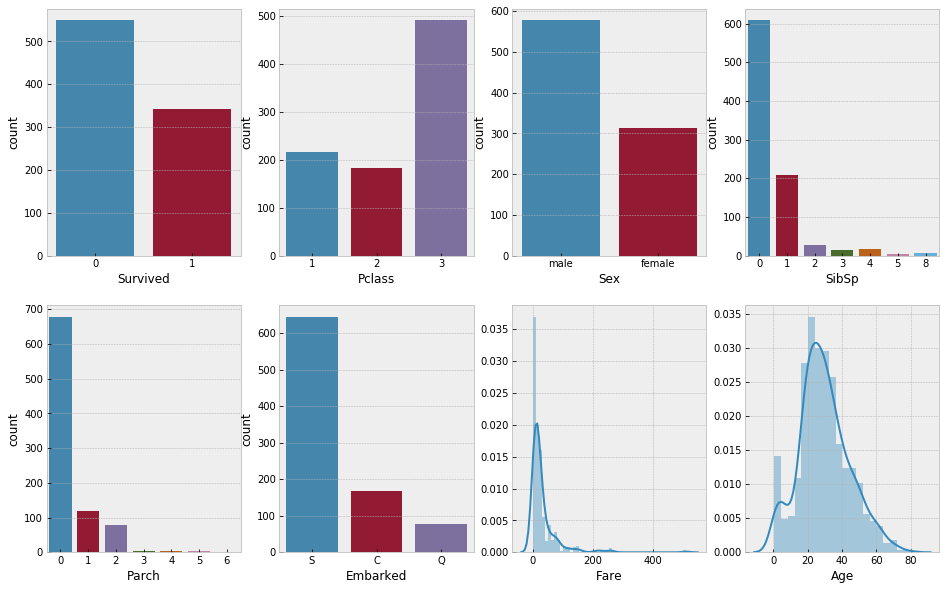

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
sns.countplot('Survived', data=train_df, ax=axes[0, 0])
sns.countplot('Pclass', data=train_df, ax=axes[0, 1])
sns.countplot('Sex', data=train_df, ax = axes[0, 2])
sns.countplot('SibSp', data=train_df, ax=axes[0, 3])
sns.countplot('Parch', data=train_df, ax=axes[1, 0])
sns.countplot('Embarked', data=train_df, ax=axes[1, 1])
sns.distplot(train_df['Fare'], kde=True, ax=axes[1, 2])
sns.distplot(train_df['Age'].dropna(), kde=True, ax=axes[1, 3])

## 2.1 Pclass & sex

Two observations can be summarized from the following graphs.
1. More than half of Class 1 passengers have larger chance of survival. <b>Likelihood of survival: Class 1 > Class 2 > Class 3.</b>
2. Most of the female survived while most male died. Female has a larger chance of survival.

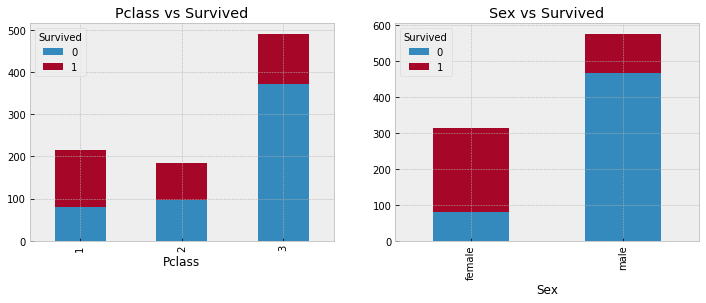

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12,4))
train_df[['Survived', 'Pclass']].pivot_table(index='Pclass',
                                             columns='Survived',
                                             aggfunc=len).plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Pclass vs Survived')
train_df[['Survived', 'Sex']].pivot_table(index='Sex',
                                          columns='Survived',
                                          aggfunc=len).plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Sex vs Survived')
plt.show()

The following line chart tells the same story.

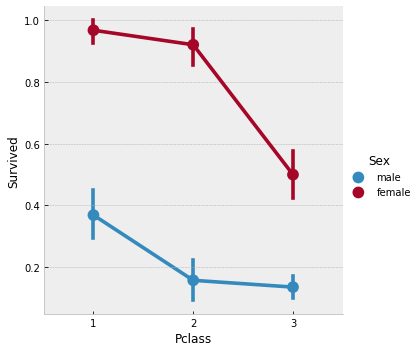

In [8]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=train_df)

## 2.2 Age

Observations on Age:<br/>
1. Most of the passengers are between 20-40 years' old.<br/>
2. The number of young children below 10 years' old increases from Class 1 to 3. Children have larger chance of survival in all three classes.<br/>
3. Class 1 passengers below 40 years' old have survival rate of higher than 50%, whereas the Class 2, 3 passengers at young ages have higher death rate.<br/>
4. Among the children below 10, the majority of young boys were saved, while most of the young girls are dead.<br/>
5. Among the passengers in the middle age, female has larger survival rate than male.

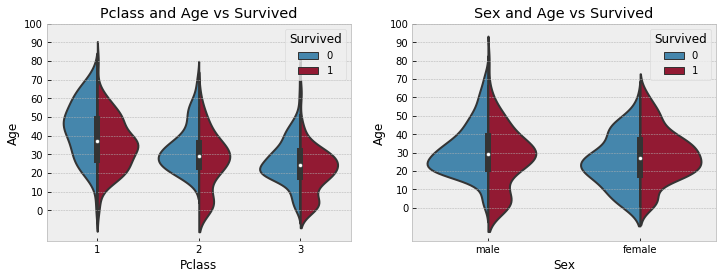

In [9]:
f, ax = plt.subplots(1, 2, figsize=(12,4))
sns.violinplot('Pclass', 'Age', hue='Survived', data=train_df, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot("Sex", "Age", hue="Survived", data=train_df, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

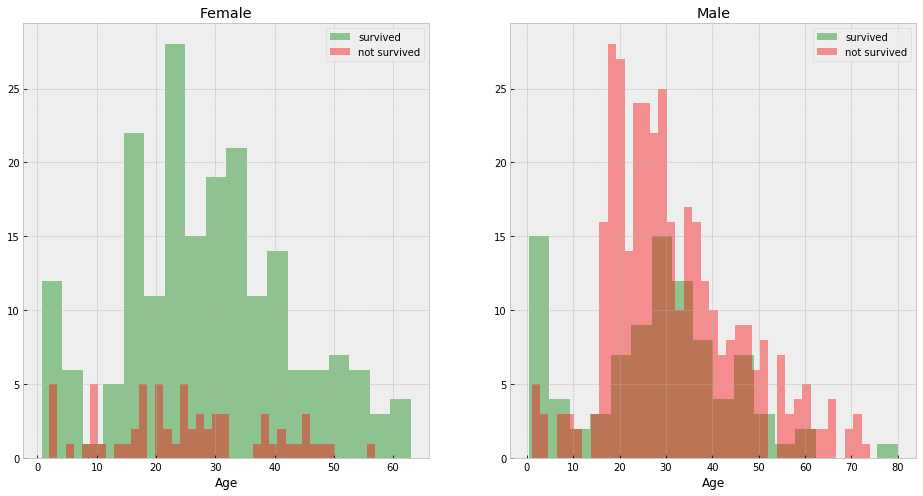

In [10]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(),
                  bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(),
                  bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male');

## 2.3 No. of family: siblings/spouses, parents/children

Observation from the following stacked bar charts:
1. Most of the passengers did not have family onboard.<br/>
2. Passengers with 1 sibling/spouse, 1 or 2 parents/children onboard has the largest survival rate.<br/>
3. Passengers with more than 1 siblings, or more than 2 children/parents have low survival rate.

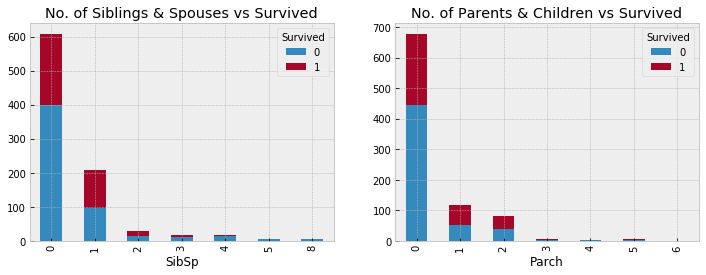

In [11]:
f, ax=plt.subplots(1, 2, figsize=(12, 4))
train_df[['Survived', 'SibSp']].pivot_table(index='SibSp',
                                            columns='Survived',
                                            aggfunc=len).plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('No. of Siblings & Spouses vs Survived')
train_df[['Survived', 'Parch']].pivot_table(index='Parch',
                                            columns='Survived',
                                            aggfunc=len).plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('No. of Parents & Children vs Survived')
plt.show()

## 2.4 Fare

It is natural to think that fare is correlated with ticket class. However, the following violin chart shows that
1. The mode of ticket fare of Class 1 > Class 2 > Class 3. Note that the passengers who pay more than 200 are filtered to yield a more explicit visualization effect.<br/>
2. Over all the three classes, <b>passengers who pay a higher fare has better chance of survival</b>.

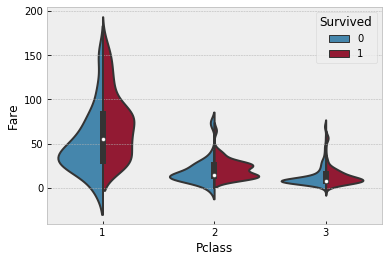

In [12]:
low_fare_train_df = train_df[train_df['Fare'] <= 200]
sns.violinplot('Pclass', 'Fare', hue='Survived', data=low_fare_train_df, split=True)

## 2.5 Embarked

Titanic set sail for Southampton, and then headed to Cherbourg and Queenstown, i.e. Southampton --> Cherbourg --> Queenstown.
<img src="input/Titanic_voyage_map.png" alt="Titanic voyage map">
Passengers who boarded from C = Cherbourg, Q = Queenstown, S = Southampton have different survival rate. This might be correlated with ticket class. The following bar charts show that
<ol>
    <li>No. of passengers who boarded at Port S > Port C > Port Q.</li>
    <li>More than half of the passengers who boarded at Port C are saved.</li>
    <li>Around half of the passengers who boarded at Port C are Class 1 passengers.</li>
</ol>

Text(0.5,1,'Class distribution of passengers boarded at port S')

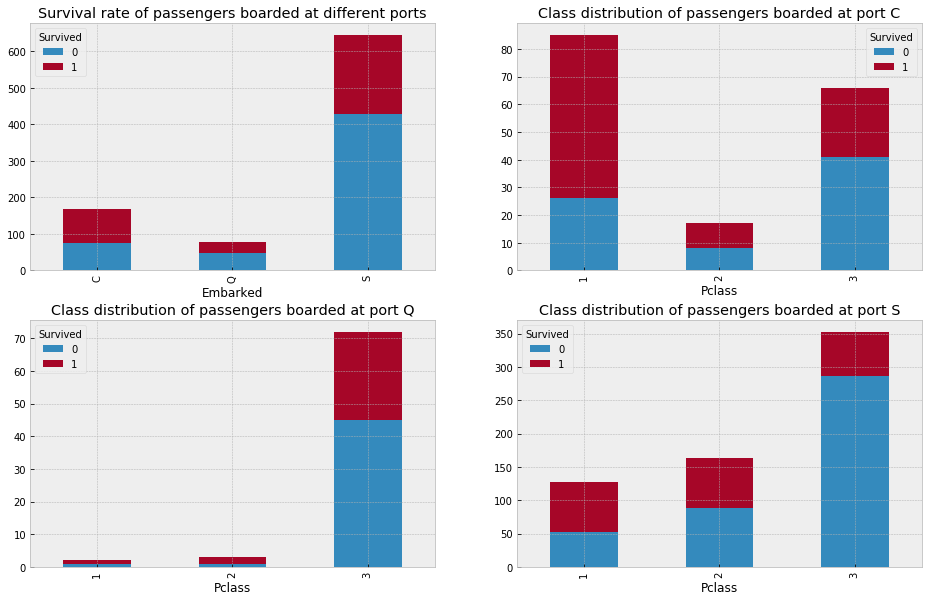

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
train_df[['Survived', 'Embarked']].pivot_table(index='Embarked',
                                               columns='Survived',
                                               aggfunc=len).plot(kind='bar', stacked=True, ax=axes[0, 0])
axes[0, 0].set_title('Survival rate of passengers boarded at different ports')
portC_train_df = train_df[train_df['Embarked'] == 'C']
portC_train_df[['Survived', 'Pclass']].pivot_table(index='Pclass',
                                                   columns='Survived',
                                                   aggfunc=len).plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Class distribution of passengers boarded at port C')
portQ_train_df = train_df[train_df['Embarked'] == 'Q']
portQ_train_df[['Survived', 'Pclass']].pivot_table(index='Pclass',
                                                   columns='Survived',
                                                   aggfunc=len).plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Class distribution of passengers boarded at port Q')
portS_train_df = train_df[train_df['Embarked'] == 'S']
portS_train_df[['Survived', 'Pclass']].pivot_table(index='Pclass',
                                                   columns='Survived',
                                                   aggfunc=len).plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Class distribution of passengers boarded at port S')

## 2.6 Cabin
<ol>
    <li>The Cabin data consists of a letter which represnets the deck or section of Titanic, followed by a room number.</li>
    <li>In this section, the data points with valid Cabin data are isolated first.</li>
    <li>The first character is taken and assign to a new column named "Deck". The numerical sequence right after this letter is assign to Room No.</li>
    <li>It can be observed that <b>the passengers with cabin have a significantly higher survival rate, especially for Cabin B-F.</b></li>
    <li><b>The passengers with smaller room number typically have a better chance of survival than the passengers with larger room number.</b></li>
</ol>

In [14]:
cabin_only = train_df[['Cabin', 'Survived']].copy()
cabin_only['Cabin_Data'] = cabin_only['Cabin'].isnull().apply(lambda x: not x)
cabin_only['Deck'] = cabin_only['Cabin'].str.slice(0,1)
cabin_only['Room'] = cabin_only['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
cabin_only['Deck'].fillna('U', inplace=True)
cabin_only.head()

,Cabin,Survived,Cabin_Data,Deck,Room
0,NaN,0,False,U,NaN
1,C85,1,True,C,85.0
2,NaN,1,False,U,NaN
3,C123,1,True,C,123.0
4,NaN,0,False,U,NaN


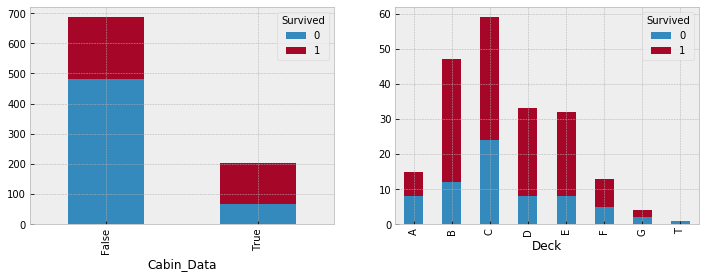

In [15]:
f, ax = plt.subplots(1, 2, figsize=(12,4))
cabin_only[['Survived', 'Cabin_Data']].pivot_table(index='Cabin_Data',
                                                   columns='Survived',
                                                   aggfunc=len).plot(kind='bar', stacked=True, ax=ax[0])
cabin_only[cabin_only["Cabin_Data"]][['Survived',
                                      'Deck']].pivot_table(index='Deck', columns='Survived',
                                                           aggfunc=len).plot(kind='bar', stacked=True, ax=ax[1])

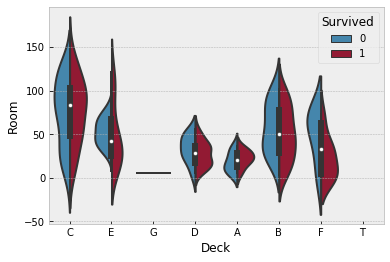

In [16]:
sns.violinplot('Deck', 'Room', hue='Survived', data=cabin_only[cabin_only["Cabin_Data"]], split=True)

# Chapter III - Feature Engineering

## 3.1 No. of family: combining SibSp and Parch

<i>'SibSp'</i> and <i>'Parch'</i> have similar impact to the chance of survival. Hence, A new feature <i>'FamilySize'</i> can be created by summing up <i>'SibSp'</i> and <i>'Parch'</i>.<br/><b>More than half of the passengers whose size of family is between 2 to 4 survived.</b>

In [17]:
train_df = pd.read_csv('input/train.csv')
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
family_size_freq = train_df['FamilySize'].value_counts().to_frame(name='Frequency')
family_size_freq = family_size_freq.reset_index()
family_size_rank = train_df[['FamilySize',
                             'Survived']].groupby(['FamilySize'], 
                                                  as_index=False).mean().sort_values(by='Survived', ascending=False)
family_size_rank.merge(family_size_freq, left_on='FamilySize', right_on='index').drop('index', axis=1)

,FamilySize,Survived,Frequency
0,4,0.724138,29
1,3,0.578431,102
2,2,0.552795,161
3,7,0.333333,12
4,1,0.303538,537
5,5,0.200000,15
6,6,0.136364,22
7,8,0.000000,6
8,11,0.000000,7


## 3.2 Passenger title
<ol>
    <li>Identify frequently appearing titles from passengers' name: 'Mrs', 'Miss', 'Master', 'Mr'. The rest of the titles would be normalized.</li>
    <li>Female passengers with title 'Mrs' have an 80% chance of survival. 'Mrs' indicates married lady and mother.</li>
</ol>

In [18]:
def extract_title(full_name):
    names = full_name.split(' ')
    for name in names:
        if name[-1] == '.':
            return name[:-1]
    return ''

In [19]:
train_df['Title'] = train_df['Name'].apply(extract_title)
title_freq = train_df['Title'].value_counts().to_frame(name='Frequency')
title_freq = title_freq.reset_index()
title_rank = train_df[['Title',
                       'Survived']].groupby(['Title'],
                                            as_index=False).mean().sort_values(by='Survived', ascending=False)
title_rank.merge(title_freq, left_on='Title',
                 right_on='index').drop('index', axis=1).sort_values(by=['Frequency'], ascending=False).head()

,Title,Survived,Frequency
12,Mr,0.156673,517
7,Miss,0.697802,182
6,Mrs,0.792000,125
8,Master,0.575000,40
11,Dr,0.428571,7


In [20]:
popular_titles = ['Mrs', 'Miss', 'Master', 'Mr']
train_df['Title'] = np.where(~train_df['Title'].isin(popular_titles), 'Other', train_df['Title'])
train_df['Title'].value_counts().to_frame(name='Frequency')

,Frequency
Mr,517
Miss,182
Mrs,125
Master,40
Other,27


## 3.3 Cabin
<ol>
    <li>Create new column "Deck" using the first letter of the existing Cabin data. Assign 'U' to null values.</li>
    <li>Create new column "Room" from the digit numbers after the first letter of Cabin. Assign mean to replace the null values.</li>
</ol>

In [21]:
train_df['Deck'] = train_df['Cabin'].str.slice(0,1)
train_df['Deck'].fillna('U', inplace=True)
train_df['Room'] = train_df['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
train_df['Room'].fillna(train_df['Room'].mean(), inplace=True)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title,Deck,Room
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr,U,50.49
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs,C,85.00
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,U,50.49
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Mrs,C,123.00
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,U,50.49


Take note that most algorithms (linear regression, logistic regression, neural network, support vector machine, etc.) require some sort of the encoding on categorical variables. This is because most algorithms only take numerical values as inputs.

Algorithms does not require encoding are algorithms can directly deal with joint discrete distribution such as Markov chain / Naive Bayes / Bayesian network, tree based, etc.

## 3.4 Age
Fit a Random Forest model to fill in the missing age values.

In [22]:
# Combine training and test datasets to have more training data with valid age values
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
combined_df = pd.concat([train_df, test_df])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


Features selected for predicting age:
<ul>
    <li>Cabin: split into Deck, Room</li>
    <li>Embarked: fill in missing value with the most popular port</li>
    <li>Fare: fill in missing value with the average ticket fare of respective class</li>
    <li>Name: extract popular titles: 'Mrs', 'Miss', 'Master', 'Mr', and the rest titles</li>
    <li>Parch</li>
    <li>Pclass</li>
    <li>Sex</li>
    <li>SibSp</li>
</ul>

In [23]:
def engineer_features(df):
    '''Process features '''
    # Cabin: Generate Deck, Room from Cabin
    df['Deck'] = df['Cabin'].str.slice(0,1)
    df['Deck'].fillna('U', inplace=True)
    df['Room'] = df['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
    df['Room'].fillna(df["Room"].mean(), inplace=True)
    
    # Embarked: Fill in missing values with the most popular port
    df['Embarked'].fillna('S', inplace=True)
    
    # Name: Generate Title
    df['Title'] = df['Name'].apply(extract_title)
    popular_titles = ['Mrs', 'Miss', 'Master', 'Mr']
    df['Title'] = np.where(~df['Title'].isin(popular_titles), 'Other', df['Title'])
    
    return df

In [24]:
selected_features = ['PassengerId', 'Age', 'Deck', 'Room', 'Embarked', 'Fare', 'Title', 'Parch', 'Pclass',
                     'Sex', 'SibSp', 'Survived']
# One-hot encode the engineered features
processed_combined_df = pd.get_dummies(engineer_features(combined_df)[selected_features])
print(processed_combined_df.columns)
processed_combined_df.head()

Index(['PassengerId', 'Age', 'Room', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Survived', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'Sex_female', 'Sex_male'],
      dtype='object')


,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male
0,1,22.0,49.615917,7.2500,0,3,1,0.0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,2,38.0,85.000000,71.2833,0,1,1,1.0,0,0,...,1,0,0,0,0,0,1,0,1,0
2,3,26.0,49.615917,7.9250,0,3,0,1.0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,4,35.0,123.000000,53.1000,0,1,1,1.0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,5,35.0,49.615917,8.0500,0,3,0,0.0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [25]:
# Filter out unwanted features
features = list(processed_combined_df.columns)
for feature in ['PassengerId', 'Age', 'Survived']:
    features.remove(feature)

processed_combined_df[processed_combined_df[features].isnull().any(axis=1)]

,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male
152,1044,60.5,49.615917,NaN,0,3,0,NaN,0,0,...,0,0,1,0,0,1,0,0,0,1


<b>The only passenger with null fare value purchased Class 3 ticket.</b>

In [26]:
avg_class3_fare = processed_combined_df[processed_combined_df['Pclass'] == 3]['Fare'].mean()

# Fill in missing value with the average Fare of class 3 
processed_combined_df['Fare'].fillna(avg_class3_fare, inplace=True)

In [27]:
null_age_df = processed_combined_df[processed_combined_df['Age'].isnull()]
not_null_age_df = processed_combined_df[processed_combined_df.Age.notnull()]
print("Number of passengers with age data: %s" %not_null_age_df.shape[0])
print("Number of passengers with no age data: %s" %null_age_df.shape[0])

Number of passengers with age data: 1046
Number of passengers with no age data: 263


Initialize random forest model with 1000 decision trees.

In [29]:
age_rf = RandomForestRegressor(n_estimators=1000, random_state=42)
age_rf.fit(not_null_age_df[features], not_null_age_df['Age'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Make prediction on the passengers with null age value.

In [30]:
null_age_df.loc[:, 'Age'] = age_rf.predict(null_age_df[features])
null_age_df.head()

,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male
5,6,28.256590,49.615917,8.4583,0,3,0,0.0,0,0,...,0,1,0,0,0,1,0,0,0,1
17,18,32.418472,49.615917,13.0000,0,2,0,1.0,0,0,...,0,0,1,0,0,1,0,0,0,1
19,20,39.096131,49.615917,7.2250,0,3,0,1.0,0,0,...,1,0,0,0,0,0,1,0,1,0
26,27,27.389190,49.615917,7.2250,0,3,0,0.0,0,0,...,1,0,0,0,0,1,0,0,0,1
28,29,21.515178,49.615917,7.8792,0,3,0,1.0,0,0,...,0,1,0,0,1,0,0,0,1,0


Combine datasets with actual age and predicted age for building machine learning models.

In [31]:
age_predicted_df = pd.concat([not_null_age_df, null_age_df])

<img src="input/titanic.jpeg" alt="Titanic newspaper">